
_The first part of this notebook was based on work by [David J. Malan](http://cs.harvard.edu/malan), which is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.](https://creativecommons.org/licenses/by-nc-sa/4.0/)._

# Convolutional Neural Networks

In previous weeks, you have implemented a Neural Network that can classify handwritten digits. If you have done any extra reading on Neural Networks, you will probably have come across the term Convolutional Neural Net, or in short CNN. CNNs are Neural Networks that specialize in image object recognition and identification. There are multiple tasks that a CNN is able to solve, but we will focus purely on image object classification. 

Neural Networks work under the assumption that each of the inputs into the network is independent. However, we know that in visual images, pixels that are at the upper left corner of an image often do not have much to do with pixels in the lower right corner. This is problem specific information that we can use to create a better model.

As often is the case in Computer Science, the solution is found in replicating nature. Scientists Hubel and Wiesel showed in the 1950s and 1960s that cat and monkey visual cortexes contain neurons that only respond to small regions in the visual field. This region of the visual field in which visual stimuli affect the firing of a single neuron is known as its receptive field. Neighbouring neurons have similar and overlapping receptive fields. In 1968, Hubel and Wiesel published a paper identifying two basic types of visual neurons; simple cells, whose output is maximized by straight lines having a particular angle in their receptive field, and complex cells, which have larger receptive fields whose outputs depend on the outputs of the simple cells within its receptive field. 

![dog](data/dog.jpg)

So how does the brain "classify" the images above as "dog on a leash"? On a small scale, one thing that might happen is that we recognize the sharp transition between the green of the background and the brown and white of the dog. These transitions form lines and the combination of these lines at certain angles can be interpreted as distinctive features of the dog, such as the ears or the nose.

This knowledge was used by Kunihiko Fukushima in 1980 where it inspired him to introduce the two basic types of layers that are still used in modern day convolutional networks: convolutional layers, and downsampling layers. Where convolutional layers have the role of the simple cells, having a maximized output by edges having a specific shape and orientation, whereas downsampling layers (also called pooling layers) have the role of the complex cells, whose output is for example an average of all pixels that are inside its receptive field. We will discuss and practice convolution and downsampling before continuing with the implementation of a CNN.

## Filters

As mentioned previously, we need "simple cells" that are able to map a group of pixels to other (hidden) values. To do this, we will implement a filter. Filters are used in many applications, and you might know of blurring filters or the "sepia" filter on your phone, but they can also be used to find sharp transitions - "edges" - in images. 

First, we will start with some basics about how images are represented on a computer. Perhaps the simplest way to represent an image is with a grid of pixels (i.e., dots), each of which can be of a different color. For black-and-white images, we thus need 1 bit per pixel, as 0 could represent black and 1 could represent white, as in the below.

![](src/bitmap.png)

In this sense, then, an image is just a bitmap (i.e., a map of bits). For more colorful images, you simply need more bits per pixel. A file format (like BMP, JPEG, or PNG) that supports “24-bit color” uses 24 bits per pixel. 

A 24-bit BMP uses 8 bits to signify the amount of red in a pixel’s color, 8 bits to signify the amount of green in a pixel’s color, and 8 bits to signify the amount of blue in a pixel’s color. If you’ve ever heard of RGB color, well, there you have it: red, green, blue.

If the R, G, and B values of some pixel in a BMP are, say, 0xff, 0x00, and 0x00 in hexadecimal, that pixel is purely red, as 0xff (otherwise known as 255 in decimal) implies “a lot of red,” while 0x00 and 0x00 imply “no green” and “no blue,” respectively. If you are not yet familiar with the hexadecimal number system, [now is the time to learn](https://www.tutorialspoint.com/hexadecimal-number-system)! A 24-bit BMP would store this bitmap as follows, where 0x0000ff signifies red and 0xffffff signifies white; we’ve highlighted all instances of 0x0000ff in red. 

![](src/red_smile.png)


### Assignment 0: Recreate the red smiley

As a quick warm-up assignment, we're going to recreate the red smiley from above in code.

Any image is just a rectangular grid of pixels, which means we can very easily represent them using *Numpy* arrays. We can use a $2$-dimensional array, with the first axis corresponding to the $x$-position of the pixel and the second axis corresponding to the $y$-position. The value of the pixel, located at that position in the array, then indicates the respective brightness of the 3 colors, in hexadecimal notation.

To simplify this a little further, we can even do without the hexadecimal notation altogether. We'll instead make a $3$-dimensional array, with first two axis still corresponding to $x$ and $y$, but the third axis now containing each of the 3 color channels separately. So `image[0, 0, 0]` would be contain the amount of *red* in the top left pixel, and `image[0, 0, 1]` the amount of *green* in that same pixel and `image[0, 0, 2]` the amount of *blue*.

Each of these colors will be represented by a float value between $0$ and $1$, where $0$ means the color is not present at all, and $1$ means the maximum brightness for that color. This means a *Numpy* array filled with all *ones* will actually always be a white image, as all 3 colors together combine to white. In order to create the smiley, you'll need set the correct parts of the green and blue channels to *zero*. 

The code below already creates a $8\times8$ white image, and also already has a list of pixel locations for the red smiley. If you run the code now, you should see a completely white image. Use the provided `pixel_list` to modify those locations in the `smiley` array to instead show the image from above.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


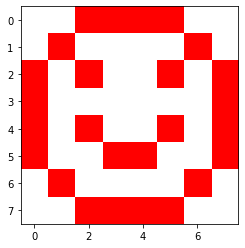

In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

smiley = np.ones((8, 8, 3))

pixel_list = [(0,2), (0,3), (0,4), (0,5),
              (1,1), (1,6),
              (2,0), (2,2), (2,5), (2,7),
              (3,0), (3,7), 
              (4,0), (4,2), (4,5), (4,7),
              (5,0), (5,3), (5,4), (5,7),
              (6,1), (6,6),
              (7,2), (7,3), (7,4), (7,5)]

# get appropriate pixel based on coordinates in pixel_list
for coordinate in pixel_list:
    
    # set pixel to red in "smiley array" to create smiley
    smiley[coordinate] = [50, 0, 0]     

plt.imshow(smiley)
plt.show()

### Assignment 1: Sepia

Most image editing programs support a “sepia” filter, which gives images an old-timey feel by making the whole image look a bit reddish-brown. An image can be converted to sepia by taking each pixel, and computing new red, green, and blue values based on the original values of the three.

There are a number of algorithms for converting an image to sepia, but for this problem, we’ll ask you to use the following algorithm. For each pixel, the sepia color values should be calculated based on the original color values per the below:

```
sepiaRed = .393 * originalRed + .769 * originalGreen + .189 * originalBlue
sepiaGreen = .349 * originalRed + .686 * originalGreen + .168 * originalBlue
sepiaBlue = .272 * originalRed + .534 * originalGreen + .131 * originalBlue
```

It is possible that the result of the formula is a number greater than 1, which is the maximum value for our colour values. In that case, the red, green, and blue values should be capped at 1.

Implement the function `sepia` below, which takes an image as input and outputs a new image of the same shape, containing the updated sepia values for each pixel. We've already imported the image and provided you with a method of displaying the image. 

**Sidenote:** You might notice the line `image = image[:,:,::-1] / 255` in the code below. Here we convert BGR to RGB as `cv2` automatically reads an image in BGR format. Dividing by 255 ensures that we are working with floats from 0 to 1 instead of with integers from 0 to 255. This means the image array loaded here works exactly the same as the red smiley example from above.

*Hint:* As the image is just a *Numpy* array, you can loop through an image using two `for` loops with `range` and loop over all the possible pixel indices. Remember that your can use [shape](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html) to get a tuple containing the size for each dimension of a *Numpy* array.


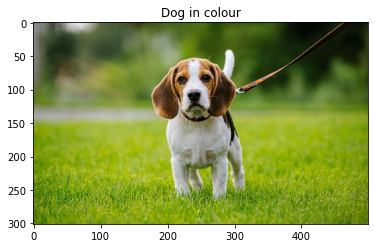

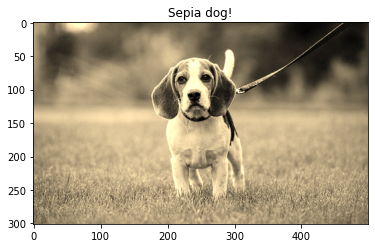

In [2]:

def sepia(image):
    '''
    Function  takes an image as input and outputs a new image of the same shape, 
    containing the updated sepia values for each pixel. 
    '''
    
    # set image to return of shape input image
    sepia_image = np.zeros(image.shape)
    
    # iterate over rows and pixels in original image
    for index_row, row in enumerate(image):
        for index_pixel, pixel in enumerate(row):
            
            # get original values RGB from original image
            originalRed = pixel[0]
            originalGreen  = pixel[1]
            originalBlue = pixel[2]
            
            # calculate sepiaRGB, cap red, green, and blue values to 1 using pandas min 
            # and store sepia RGB in correct sepia_image pixel
            sepia_image[index_row, index_pixel, 0] = min((0.393 * originalRed + 0.769 * originalGreen + 0.189 * originalBlue), 1)
            sepia_image[index_row, index_pixel, 1] = min((0.349 * originalRed + 0.686 * originalGreen + 0.168 * originalBlue), 1)
            sepia_image[index_row, index_pixel, 2] = min((0.272 * originalRed + 0.534 * originalGreen + 0.131 * originalBlue), 1)
            
    return sepia_image


# Read image and transform from BGR to RGB
image = cv2.imread('data/dog.jpg')
image = image[:,:,::-1] / 255

plt.imshow(image)
plt.title('Dog in colour')
plt.show()

sepia_image = sepia(image)

plt.imshow(sepia_image)
plt.title("Sepia dog!")
plt.show()


### Assignment 2: Grayscale

Recall that if the red, green, and blue values are all set to 0x00 (hexadecimal for 0), then the pixel is black. And if all values are set to 0xff (hexadecimal for 255), then the pixel is white. If, for our image, all we care about is black, white and values in between (i.e. gray), then we don't even need the 3 RGB channels, as a single channel can contain all the information! This channel will then just indicate how much white there is for each pixel, with higher values meaning lighter shades (closer to white) and lower values meaning darker shades (closer to black).

Implement the function `grayscale` which takes an RGB image and outputs a new image of the same dimensions, but containing only a single channel with the grayscale values. Combine the values from the R, G and B channel into a single channel for each pixel by computing the average brightness of that pixel across all channels.

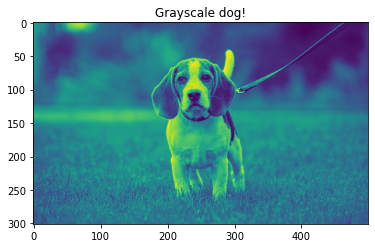

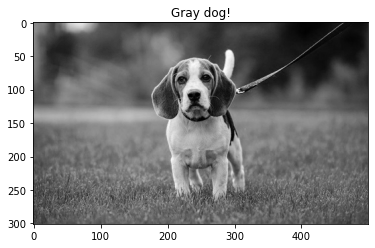

In [3]:
def grayscale(image):
    '''
    Function  takes an RGB image and outputs a new image of the same dimensions, 
    but containing only a single channel with the grayscale values. 
    '''
    
    # set empty image based on input image
    gray_image = np.zeros((image.shape[0], image.shape[1]))
    
    # iterate over rows and pixels in original image
    for index_row, row in enumerate(image):
        for index_pixel, pixel in enumerate(row):
            
            # compute the average brightness of that pixel across all channels
            average = pixel.mean()
            
            # store average in correct gray_image 
            gray_image[index_row, index_pixel] = average
            
    return gray_image

gray_image = grayscale(image)

plt.imshow(gray_image)
plt.title("Grayscale dog!")
plt.show()

# Note that if we want to actually show the picture in grayscale, 
# we have to tell Matplotlib to treat it this way, as it will automatically use its yellow and blue colormap
plt.imshow(gray_image, cmap="gray")
plt.title("Gray dog!")
plt.show()

### Assignment 3: Blur

There are a number of ways to create the effect of blurring or softening an image. For this problem, we’ll use the simplest approach; the “box blur”. A box blur works by taking each pixel and averaging the color values of neighbouring pixels, for each color value. This "neighbourhood" forms a simple 3x3 "box", which is where the method gets its name. By averaging values in this local area, the effect is to blur the image. Consider the following grid of pixels, where we’ve numbered each pixel.

![](src/grid.png)

The new value of each pixel will be the average of the values of all of the pixels that are within 1 row and 1 column of the original pixel (forming a 3x3 box, or "patch"). For example, each of the color values for pixel 6 would be obtained by averaging the original color values of pixels 1, 2, 3, 5, 6, 7, 9, 10, and 11 (note that pixel 6 itself is included in the average). Likewise, the color values for pixel 11 would be obtained by averaging the color values of pixels 6, 7, 8, 10, 11, 12, 14, 15 and 16. The name for an area of an image that we apply the average to, is a **patch**.

For a pixel along the edge or corner, like pixel 16, we have a problem that will need to be solved. Clearly, we'll need to use pixels 11, 12, 15 and 16 in the average, but then we're still missing 5 values for our patch, as there are no values for the pixels that are to the right or to the bottom of pixel 16. There are many solutions to this problem, some of which are:

- Padding: adding "extra" pixels around the border with a specific value like 0.
- Crop: Any pixel in the output image which would require values from beyond the edge is skipped. This method can result in the output image being slightly smaller, with the edges having been *cropped*
- Wrap: the image is wrapped around on both axes, so pixels outside of the border become pixels from the opposite side of the image.
- Mirror: the image is mirrored at the edges. For example, attempting to read a pixel 3 units outside an edge reads one 3 units inside the edge instead

Implement the function `blur` that takes a **grayscale** image and returns a new blurred image, consisting of the averages of a sets of pixels within the area of the given box size. The computed output pixels for the new image should always be located at the *center* of the box, so a box size of 3 means you should consider all pixels with a difference of at most 1 for rows and/or columns, in either direction (positive or negative), to be part of that 3x3 patch.

Use either the padding or cropping method described above to solve the edge problem. Note that, depending on the method you select, your output image might be of a different size than the input. Start by creating a new image of the correct shape first, and then fill all the pixels with their blurred values. You do not have make your code work for anything other than grayscale images, so you may assume input images will always be $2$-dimensional.

*Hint:* You should loop over each of the *output* image pixel indices, and then determine which are the relevant *input* images pixels, around that center pixel, to include in your blur for that output pixel, using your selected method to deal with edges. You can use [slicing](https://numpy.org/doc/stable/reference/arrays.indexing.html) to select these input image pixels and use [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) to then average these patches of pixels.

**Note:** It might be difficult to see the blurring effect on the dog when using the standard 3x3 box. Try the smiley from before, or use a bigger box (e.g. 11x11), to see the blurring effect more easily.


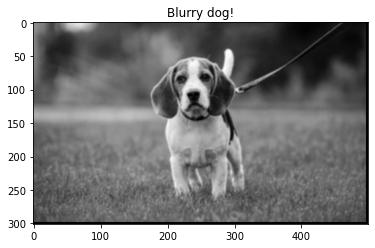

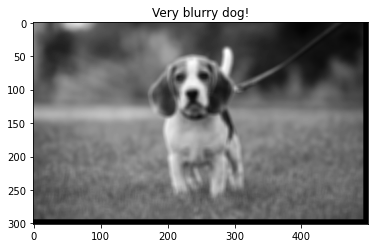

In [4]:
def blur(image, size = 3):
    '''
    Function takes a grayscale image (2D) and returns a new blurred image, consisting of the averages 
    of a sets of pixels within the area of the given box size. Function relies on crop method: 
    Any pixel in the output image which would require values from beyond the edge is skipped.
    '''
    
    # set empty image for blurred image, based on input image
    blur_image = np.zeros((image.shape[0], image.shape[1]))
    
    # crop original image to skip any pixel in the output image which would require values from beyond the edge
    image_width = image.shape[0] - size
    image_length = image.shape[1] - size
    
    # loop over cropped input image
    for x in range(image_width):
        for y in range(image_length):
            
            # set mask for box (= patch)
            box = image[x : x + size, y : y + size]
            
            # calculate the average of this patch of pixels.
            mean_box = np.mean(box)            
            
            # store average in correct place for the blurred image 
            blur_image[x , y] = mean_box

    return blur_image

blur_image = blur(gray_image)

plt.imshow(blur_image, cmap="gray")
plt.title("Blurry dog!")
plt.show()

blur_image = blur(gray_image, size = 7)

plt.imshow(blur_image, cmap="gray")
plt.title("Very blurry dog!")
plt.show()

## Convolution

What we did for the box blur was to take a simple average of each patch. The more general version of this is to take a weighted average, where each pixel in a patch gets its own weight. The name of the matrix of weights is a **kernel** and computing the resulting value is called **convolution**. So, convolution is the process of multiplying each pixel in a patch by its respective weight in the kernel and summing the result. Let's take a look at how convolution would work for a single patch in an image with 9 pixels numbered 1 to 9:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$$

In linear algebra, convolution is often depicted by using a $*$. If we convolute a kernel that is three-by-three (represented by a matrix filled with a to i) with the pixel numbered 5 (located at the coordinate [2,2]) in our example above, it would look something like this:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
*
\begin{bmatrix}
a & b & c \\
d & e & f \\
g & h & i
\end{bmatrix}
= 
(a \cdot 1)+(b \cdot 2)+(c \cdot 3)+(d \cdot 4)+(e \cdot 5)+(f \cdot 6)+(g \cdot 7)+(h \cdot 8)+(i \cdot 9).
$$

The general form for matrix convolution is:

$$
\begin{bmatrix}                                                                  
  x_{11}       & x_{12} & \cdots  & x_{1n} \\                                    
  x_{21}       & x_{22} & \cdots  & x_{2n} \\                                    
  \vdots       & \vdots & \ddots  & \vdots \\                                    
  x_{m1}       & x_{m2} & \cdots  & x_{mn} \\                                    
\end{bmatrix}                                      
*
\begin{bmatrix}                                                                  
  h_{11}       & h_{12} & \cdots  & h_{1n} \\                                    
  h_{21}       & h_{22} & \cdots  & h_{2n} \\                                    
  \vdots       & \vdots & \ddots  & \vdots \\                                    
  h_{m1}       & h_{m2} & \cdots  & h_{mn} \\                                    
\end{bmatrix}                                                                       
= \sum^{m}_{i=1} \sum^{n}_{j=1}                                              
   x_{ij} h_{ij}
$$

Where $m$ and $n$ are the width and height of the kernel $h$ and an image patch $x$ of the same size.

Unknowingly, you have already implemented your first convolution method! Blurring an image can be done by creating a kernel that has an equal weight for all pixels in the receptive area. The weights are then normalized, such that the total is 1 and the resulting value for a convolution can never exceed the maximum value for a pixel. For a blurring with a kernel of size 3, this would look like:

$$
h=
\frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

### Assignment 4a: Convolution

Implement a function `convolution` that takes two matrices of the same size and applies a convolution. The result of the function should be a single float. Note that the matrix example above is one-indexed, while your code will be zero indexed. Make sure to test the function yourself by making a couple of filters and seeing if the results of the convolution are what you expect them to be. 

In [5]:
def convolution(x, h):
    '''
    Function takes two matrices of the same size and applies a convolution.
    '''
    
    # get width and length of image for iteration
    width = x.shape[0]
    length = x.shape[1]
    
    # set variable for total sum of the matrices
    sum_matrices = 0
    
    # loop over matrices and update total sum of those matrices
    for row in range(width):
        for column in range(length):
            sum_matrices += x[row, column] * h[row, column]
    
    return sum_matrices


# test convolution function
x = np.array([[1, 2, 3], [4, 5, 6],[7, 8, 9]])
h = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])

# apply convolution function
convulution_outcome = (convolution(x,h))

# set variable for correct outcome
correct_outcome = 45

# test outcome
if convulution_outcome == correct_outcome:
    print(f"{convulution_outcome} - seems correct")
       

45 - seems correct


### Assignment 4b: Convolve

The next step in the process is to apply our `convolution` function to compute the output for every pixel in our image. Implement the function `convolve`, that accepts an `image` and a square kernel `h`. 

The function should separate the appropriate patch of pixels, and use the `convolution` function to apply the kernel to that area. This should be repeated for each patch, until the new image has been completely constructed. Your function only needs to work for grayscale images, so just a single color channel for the input and output images.

The output of each convolution is located at the **center** of the kernel and so you'll need to use your code from `blur` to solve the same edges problem. As a result, the implementation of this function will actually be pretty close to the `blur` function. We've already prepared some code that should blur the image in just the same way as your `blur` function, but now using convolutions.


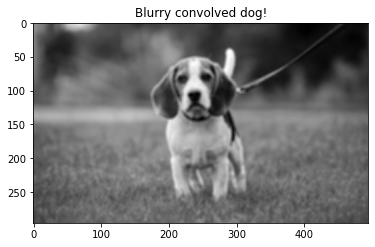

In [6]:
def convolve(image, h):
    '''
    Function applies convolution function to compute the output for every pixel in our image. 
    It accepts an image and a square kernel. For every patch, separate the appropriate patch of pixels,
    and uses the convolution function to apply the kernel to that area. 
    '''
    
    # set variable for kernel size
    size = len(h)
    
    # crop image to skip any pixel in the output image which would require values from beyond the edge
    image_width = image.shape[0] - size
    image_length = image.shape[1] - size
    
    # set empty image for convoluted image
    convoluted_image = np.zeros((image_width, image_length))
    
    # loop over cropped input image
    for x in range(image_width):
        for y in range(image_length):
            
            # set mask for box
            box = image[x : x + size, y : y + size]
            
            # calculate the convolution of these patches of pixels.
            convolution_box = convolution(box, h)         
            
            # store average in correct place for the convoluted image 
            convoluted_image[x, y] = convolution_box

    return convoluted_image

# You can change this to increase the blurring area
kernel_size = 5

# Normalize the filter
blur_filter = (1 / kernel_size ** 2) * np.ones((kernel_size, kernel_size))

blur_convolve_image = convolve(gray_image, blur_filter)

plt.imshow(blur_convolve_image, cmap="gray")
plt.title("Blurry convolved dog!")
plt.show()

Let's test your convolution function with some commonly used kernels! You will notice that they are almost always symmetrical, but of course we are not limited by this! Another thing you might notice is that a lot of kernels are scaled to ensure the sum of all the weights is 1. Normalizing this way ensures the resulting image does not get brighter or darker by applying the kernel to the image.

### Assignment 5a: Gaussian blur

Instead of assuming that each pixel in the receptive field is equally important, such as we have done with our earlier blurring filters, we can also create a filter that takes the distance of pixels into consideration. One such filter is the Gaussian blur filter. This filter can be created in any size, as the actual Gaussian distribution is continuous. When creating this kernel, we compute a discrete approximation of a certain size of that same continuous distribution. It creates the effect of viewing the image through a translucent screen and larger kernels naturally result in a more blurry image.

For example, this is a Gaussian blur kernel of size 3x3

$$
h=
\frac{1}{16}
\begin{bmatrix}
\ \ 1 &\ \  2 &\ \  1 \\
\ \ 2 &\ \  4 &\ \  2 \\
\ \ 1 &\ \  2 &\ \  1
\end{bmatrix}
$$

And this is a Gaussian blur kernel of size 5x5

$$
h=
\frac{1}{256}
\begin{bmatrix}
1 & 4 & 6 & 4 & 1 \\
4 & 16 & 24 & 16 & 4 \\
6 & 24 & 36 & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 & 4 & 6 & 4 & 1
\end{bmatrix}
$$

As you can see, these filters are properly normalized, and thus will not make the resulting image brighter or darker.

Implement the 5x5 Gaussian filter and observe its effects. Do you notice a big difference with our previous blurring filter?

**NOTE:** You don't need to compute the values of a 5x5 Gaussian filter, but can just use the values provided above!

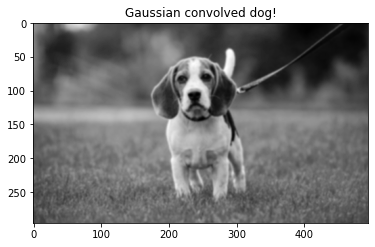

In [7]:
# set filter
gauss_filter = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])

# set gaussian blur kernel
gauss_filter = 1 / 256 * gauss_filter

# implement the 5x5 Gaussian filter
gauss_image = convolve(gray_image, gauss_filter)

plt.imshow(gauss_image, cmap="gray")
plt.title("Gaussian convolved dog!")
plt.show()

### Assignment 5b: Sharpening

In a sharpening filter, transitions towards a pixel are amplified. The most simple method gives good results, but is a bit aggressive:

$$
h=
\begin{bmatrix}
\ \ 0 & -1 & \ \ 0 \\
-1 & \ \ 5 & -1 \\
\ \ 0 & -1 & \ \ 0
\end{bmatrix}
$$

The effect is to make each pixel *less* blurry, by subtracting the values from the surrounding pixels. This second one, named an "Unsharp masking"-filter, is based on a gaussian blur and is therefore slightly less sensitive to noise in the picture.

$$
h=
\frac{-1}{256}
\begin{bmatrix}
1 & 4 & \ \ 6 & 4 & 1 \\
4 & 16 & \ \ 24 & 16 & 4 \\
6 & 24 & -476 & 24 & 6 \\
4 & 16 & \ \ 24 & 16 & 4 \\
1 & 4 & \ \ 6 & 4 & 1
\end{bmatrix}
$$

Implement a 5x5 unsharp masking filter and observe its effects. 

**Note:** This filter might produce values that do not fall in the range *0-1*. The easiest way to solve this is to use `np.maximum` and `np.minimum` to ensure the minimum value is 0 and maximum value is 1 for each pixel.

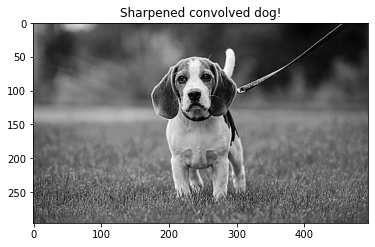

In [22]:
# set filter
sharp_filter = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, -476, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])

# set sharpening kernel
sharp_filter = -1 / 256 * sharp_filter

# implement the 5x5 sharpening filter
sharp_image = convolve(gray_image, sharp_filter)

sharp_image = np.maximum(sharp_image, 0)
sharp_image = np.minimum(sharp_image, 1)

plt.imshow(sharp_image, cmap="gray")
plt.title("Sharpened convolved dog!")
plt.show()

### Assignment 6: Edge detection

Edge detection is an integral part of identifying objects in images and aims at identifying points at which the image brightness changes sharply. The theory is that large discontinuities in image brightness correspond to depth changes, surface orientation, material properties, illumination, etc. An example of two simple edge detection kernels is:

$$
h=
\begin{bmatrix}
1 & 0 & -1 \\
0 & 0 & 0 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
h=
\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{bmatrix}
$$

Where the first kernel primarily reacts to edges that are diagonal, and the second kernel reacts to transitions in every direction, which makes it very sensitive to noise. To cope with this issue, most edge detection methods require you to first apply a blur to the image. 

A more complex method of finding edges in an image is the "Canny edge detector". This is in fact a multi-stage algorithm that can detect a wide range of edges in imagery and is grounded in mathematics. We will not discuss all the steps in the algorithm, but a large part of it is based on finding the so-called intensity gradients of each pixel. These gradients are calculated by using an edge detection filter that can calculate partial derivatives of the gradient in the horizontal and vertical directions. One method to get these gradients is the Sobel filter.

The Sobel filter uses two kernels with size 3 to get the gradient in the horizontal direction ($\mathbf{G}_x$) and in the vertical direction ($\mathbf{G}_y$):

$$
\mathbf{G}_x = \mathbf{A} * 
\begin{bmatrix} 
 1 & 0 & -1  \\
 2 & 0 & -2 \\
 1 & 0 & -1 
\end{bmatrix}
\quad
\mbox{and}
\quad   
\mathbf{G}_y = \mathbf{A} *
\begin{bmatrix} 
 1 & 2 & 1\\
 0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
$$

Here, $\mathbf{A}$ is a patch of the image on which you want to apply the Sobel filter, while the matrices are the horizontal and vertical filters. Each of these filters can be decomposed into two elements (vectors). One is a vector kernel that is based on Gaussian smoothing: $[1 \ 2 \ 1]$. While the other is a differentiation vector kernel: $[1 \ 0 \ -1]$. You can view this differentiation kernel as a simplification of the actual gradient of a point on a line. Simply take the difference to the left and to the right of a point and we have an approximation of the actual gradient. A [more formal explanation can be found on Wikipedia](https://en.wikipedia.org/wiki/Sobel_operator#More_formally). These approximations of the partial derivatives in the *x* and *y* direction of the image can then be used to calculate an approximation of the *magnitude of the gradient* $\mathbf{G}$:

$$\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$$

This magnitude indicates how large the combined gradient is in both the *x* and *y* directions and is the perfect indicator for interesting areas in the image: if the magnitude is large, then there is a steep transition of color around that pixel, and if it is zero there is no transition of color around that pixel, which probably indicates this is a "less interesting" part of the image.

**Sidenote:** Something that is also possible, *but that we will not use here*, is that we can get an approximation of the *gradient direction* $\mathbf{\Theta}$. This can be useful if you are only interested in edges going in specific directions.

$$\mathbf{\Theta} = \operatorname{atan}\left(\frac{\mathbf{G}_y}{\mathbf{G}_x}\right)$$

Implement the two sobel filters, convolve them with the grayscale image, and finally calculate the magnitude of the gradient $\mathbf{G}$ for every pixel in the image.

**Important:** Define your two filters as `x_sobel_filter` and `y_sobel_filter`, as we will use them later in this notebook using those specific names.

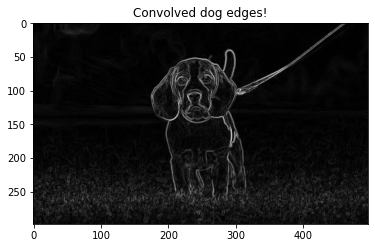

In [9]:
# define two filters as x_sobel_filter and y_sobel_filter
x_sobel_filter = np.array([[1, 0, -1], [2, 0, -2],[1, 0, -1]])
y_sobel_filter = np.array([[1, 2, 1], [0, 0, 0],[-1, -2, -1]])

# set two kernels with size 3 to get the gradient in the horizontal and vertical direction
Gx = convolve(gray_image, x_sobel_filter)
Gy = convolve(gray_image, y_sobel_filter)

# calculate the magnitude that indicates how large the combined gradient is in both the x and y directions
sobel_magnitude = np.sqrt(np.square(Gx) + np.square(Gy))

plt.imshow(sobel_magnitude, cmap="gray")
plt.title("Convolved dog edges!")
plt.show()

## Downsampling - Pooling

Earlier in this notebook we referred to a second type of cells, whose output is a complex combination of all signals in its receptive field. Even though these cells were named "complex" by Kunihiko Fukushima, the equivalent operations within a Convolutional Neural Network are easy to understand and implement. Their equivalent in Convolutional Neural Networks is named a Pooling layer. These layers have the role of downsampling information, such that the amount of calculations that is required in the next set of layers is decreased. This is done by reducing the spatial size of the intermediate outputs of the layers. This not only reduces the amount of computation necessary but also protects against overfitting.

Again, the main principle of pooling is very simple. Large matrices are reduced in size to become smaller ones. One of the most commonly used pooling techniques is called **max-pooling**, wherein only the maximum value within a receptive field is kept, and the other values are discarded.

![](src/pooling.png)

The size of this rectangle is still called the **kernel size**, and the number of steps to where the next kernel will start is named **stride**. In the image above, an example of max-pooling is shown, where the kernel size is $(2, 2)$ and the stride is 2 as well. The input image is partitioned into a set of rectangles, and for each region the maximum value is determined. 

![](src/stride1.png)

The picture above shows the effect of a pooling operation with a kernel size of $(3, 3)$ and a stride of 1. A stride of 1 is not commonly used, as it does not greatly affect the size of the output enough (which is the goal of pooling)

![](src/stride2.png)

The picture above shows the effect of a pooling operation with a kernel size of $(3, 3)$ and a stride of 2. Increasing the stride will decrease the number of pixels in the output quadratically. Setting the stride even bigger than the kernel size will result in some pixels being skipped entirely.

**Sidenote:** For a network, pooling provides a form of translation invariance; it does not matter if the network is activated slightly to the left, right, up, or down, as the pooling operation ensures that only the "most important" features in the receptive region are taken into account. In other variants of pooling, you might take the average, or the minimum.


**Q1. Argue why pooling would also control overfitting.**

* Overfitting occurs when the model is fitted to the training set, to such an extent that our training accuracy will be high, whereas the accuracy on the validation/test will be lower.In order to prevent overfitting, you'd need to make sure that the model is able to better generelize to new data. One way of doing so is by augmenting the data so that the model is not trained precisely on the training data, but on more general features of that training data. Pooling can do just that by reducing the amount of pixel in the picture. This prevent overfitting as the model will be trained on more general features of the training data, as opposed to all specific features of that data.*

### Assignment 7: Max pooling

Implement the function `max_pool` below, where`kern_size` is a tuple defining the area wherein you determine the maximum, and `stride` indicates the number of steps you take before determining a new maximum. The output dimensions of the matrix can be calculated easily:

$$ width_{output} = \lfloor \frac{width_{input} - width_{kernel}}{stride} + 1 \rfloor$$

$$ height_{output} = \lfloor \frac{height_{input} - height_{kernel}}{stride} + 1) \rfloor$$

Try to experiment with different inputs and see if they produce the correct output. Include tests that try out asymmetrical kernels and smaller and bigger strides.

**Hint:** use [slicing](https://numpy.org/doc/stable/reference/arrays.indexing.html) and `np.max`! The $$\lfloor \rfloor$$ signs stand for the "flooring" operation; rounding down. You can use `math.floor()`, or cast to an `int()` to achieve this.

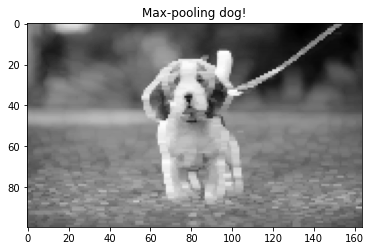

In [10]:
def max_pool(image, kern_size, stride):
    '''
    Function implements max_pool: input kern_size is a tuple defining the area wherein you determine the maximum,
    and stride indicates the number of steps you take before determining a new maximum.
    '''
    
    # calculate output dimensions of the matrix
    width_input = image.shape[0]
    width_kernel = kern_size[0]
    height_input = image.shape[1]
    height_kernel = kern_size[1]
    width_output = int((width_input - width_kernel) / stride + 1)
    height_output = int((height_input - height_kernel) / stride + 1)
    
    # set output image
    output_dimensions = np.zeros((width_output, height_output))
    
    # loop over cropped input image
    for x in range(width_output):
        for y in range(height_output):
            
            # implement stride
            x_start = x * stride
            y_start = y * stride
            
            # set mask for box (= patch)
            box = image[x_start : x_start + width_kernel, y_start : y_start + height_kernel]
            
            # calculate the max of this patch of pixels
            max_box = np.max(box)            
            
            # store average in correct place for the output image 
            output_dimensions[x , y] = max_box

    return output_dimensions

pooled_image = max_pool(gray_image, (2, 10), 3)

plt.imshow(pooled_image, cmap="gray")
plt.title("Max-pooling dog!")
plt.show()

### How does this translate to a Convolutional Neural Network?

![](src/CNN.png)

The main idea of CNNs is to extract features from the original input by applying convolutions with different filters. The topological overview of a typical CNN is displayed in the image above. A CNN can be separated into two phases. The first phase is the feature extraction, and the second phase is classification, where the features extracted in the extraction phase are used. 

The input in the CNN depicted above is a picture of two boats along a dock. In the feature extraction phase, convolution is applied to this image, and the output of this convolution is called a **feature map**. Now, if you look closely, you can see that there are multiple (in this case three) feature maps "stacked" on top of each other. This is a result of the application of multiple (in this case three) different filters all convolved with the original image concurrently. Each of these feature maps will try to extract a different set of features from the original image. The resulting feature maps are all subsampled in a pooling layer, resulting in a multitude (again, in this case three) of smaller feature maps. This process of first applying convolution and then applying pooling can be repeated multiple times, where the idea is to increase the number of extracted features, while reducing the complexity of these features. This is often done until there are many feature maps that are only a couple of pixels in size.

In the classification phase, the resulting feature maps are **flattened**; the pixels are rearranged to form a vector. This flattened feature array is then inserted into a fully connected network, that is essentially the same as any Neural Network that you would use for classification. *Thus, a convolutional neural network is a neural network that uses convolutions at some of the layers to extract relevant features for the final classification.*

# Keras and TensorFlow

Up to this point, we've been defining all these convolutional kernels by hand, designing different useful features, like those that can detect edges in an image. However, as we'll see later in this assignment, ideally you would want to *learn* what the best convolutional kernels are to use for your classification problem. Learning these convolutional kernels can be done in the exact same way as for regular neural networks, namely using *backpropagation*. The equations change slightly, because now the weight in a convolutional kernel contributes to many different outputs at once, instead of just a single node activation, but the principle remains exactly the same: Use the chain-rule to decompose each of the different partial derivatives step by step and find the gradient determining how to change these weights to improve the classification output on the training data.

Programming your own learnable convolutional neural network layers is definitely possible, but can be a little tricky and is actually not that interesting, given you already understand the core principles at work here, namely convolution and backpropagation. In addition, there are quite a few good libraries that offer this functionality already implemented, which we can use for our experiments. One of the most well known and easiest to use is [Keras](https://www.tensorflow.org/api_docs/python/tf/keras), which already comes included with [TensorFlow](https://www.tensorflow.org/), Google Brain's machine learning library. For the second part of this assignment we'll be getting started with Keras and combining it with our own convolutions from before!


## Application - MNIST Fashion


Before we build these CNNs, let's load the data we'll use for this assignment, which comes from the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset. This dataset was made by Zalando using their own article's images and shares the same image size and structure of training and testing splits: it consists of a training set of 60,000 examples and a test set of 10,000 examples, where each example is a 28x28 grayscale image, associated with a label from 10 classes:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

The code below loads the data (it comes already included with the Keras library) and shows you what this data looks like.

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)


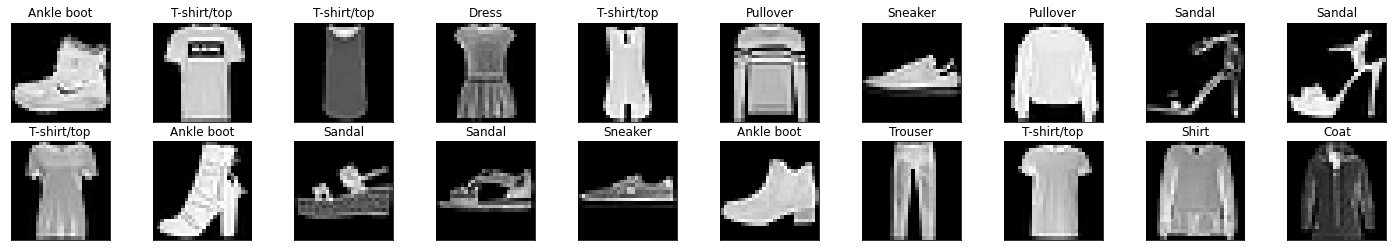

First 5 training labels:
 [9 0 0 3 0]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
# Load the required libraries for the next part of the exercise
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Training data shape: ", x_train.shape) 
print("Test data shape", x_test.shape)

# Image size is 28*28
image_size = x_train.shape[1] * x_train.shape[2]

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' )

# Show the first 20 samples
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[i], cmap='gray')
    ax.set_title(classes[y_train[i]])

plt.show()

print("First 5 training labels:\n", y_train[:5]) 

# Convert to "one-hot" vectors
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])

Now that we have loaded the data, and have the training and testing dataset ready, let's first take a look at building a basic Neural Network using *Keras*.

We'll build a simple network, using 784 input nodes (each image is 28x28 = 784 pixels large), 64 hidden nodes with a Sigmoid activation and 10 output nodes (same as the number of classes we're trying to learn) with a Softmax activation.

Building this type of network using *Keras* is not that hard, but we'll go through it step by step. Let's start by importing the relevant Keras modules

    from tensorflow.keras import layers, models

The first real step is to initialize the model:

    model = models.Sequential()

This creates a model of the type `Sequential`, which just means that all the layers will be stacked one after the other, i.e. the output of one layer becomes the input of the next layer. Other types of models are possible, but `Sequential` is *by far* the most common type. Once a `Sequential` model has been initialized, you can simply use `model.add()` to add another layer to your network:

    model.add(layers.Dense(units=64, activation='sigmoid', input_shape=(784,)))
    
This adds a `Dense` layer to the network, which has 64 nodes, each with a Sigmoid activation and whose input is the same size as the inputs we're trying to classify. The fact that it is a `Dense` layer, means the inputs are *fully-connected* to the output, i.e. there are weights connecting each input to each output. This means this layer will have 784 x 64 = 50176 weights and 64 biases.
    
    model.add(layers.Dense(units=10, activation='softmax'))
    
Next, we just add another `Dense` layer with 10 output nodes, so one for each class we're trying to learn, with a Softmax activation. Note that here we don't even have to specify that we need 64 inputs. Keras will infer this automatically, because we're using a `Sequential` model, so the output size of the previous layer will become the input size for the next layer.
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy']) 
   
Finally, we compile this model, which means specifying what the loss / cost function is we want to optimize for this model and what other metrics we want to keep track of. Here we'll use the *categorical crossentropy* loss, which is just another name for the same negative log likelihood function we used in combination with a softmax output layer before. In addition, we'll tell Keras we want to know what the accuracy of the model is too, not just the loss, as this will be easier to interpret. 

Below the function `build_neural_net()` has already been provided, which implements these exact steps. The only difference here is that the number of inputs, hidden nodes and classes to predict have become arguments of the function instead of fixed numbers. To create the same network as described above, you would simply call the function as:

    model = build_neural_net(784, 64, 10)


In [12]:
from tensorflow.keras import layers, models

def build_neural_net(input_size, hidden_nodes, num_classes):
    # Create a sequential model object
    model = models.Sequential()

    # Create the hidden layer with sigmoid activations
    model.add(layers.Dense(units=hidden_nodes, activation='sigmoid', input_shape=(input_size,)))
    
    # Create the output layer with softmax activations
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    
    # Compile the network with the appropriate loss function and keep track of accuracy
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

As you might have noticed from the previous section, creating a Neural network using *Keras* is really quite simple. However, this just builds the structure of the network, but doesn't learn the weights of the network yet. Luckily, learning the best weights for the network is perhaps even easier, as we'll really only need to use one function: `fit`.

What the `fit` does is take training inputs *X* and training outputs *Y* and actually performs the entire Gradient Descent algorithm from start to finish! (Sidenote: to be exact, by default `fit` will use RMSProp, which is a little more complicated version of Gradient Descent that tends to converge to a minimum loss much faster, but it follows the same principles). Besides the training data *X* and *Y*, the fit function takes some other useful arguments:

**Batch size:** As discussed in the previous module on neural networks, when a data set becomes large enough, it's usually necessary to use a mini-batch version of gradient descent to speed up training, instead of using the entire data set to do a single step of gradient descent. This parameter specifies the size of each batch to use in training.

**Epoch:** An epoch indicates a complete pass of the entire training set by the algorithm. This means enough batches have been processed by gradient descent, that each sample in the training set was seen exactly *once*. Because a single step of mini-batch gradient descent can actually increase the loss, we cannot simply test for convergence of the algorithm, so instead we just specify to repeat the training for this many epochs. 10 epochs means that we will train the model on the entire training set 10 times, after which gradient descent will stop.

**Validation split:** Here we can specify what percentage of the data to use for validation. The fit function will actually take this validation set and evaluate it after each epoch, so we can easily plot the learning curves to see if we've overfit! After each epoch, the training and validation loss will be printed, in addition to any other metrics we specified when compiling the model.

Before we can actually use the `fit` function, we'll need to flatten the *X* inputs, which means the 28x28 pixels of each image will be rearranged into a single flatten vector/array. This means that we lose the spatial relation between pixels, but we can now use them as input for the fully connected neural network.

In [13]:
model = build_neural_net(image_size, 64, num_classes)

# Flat
x_train_flat = x_train.reshape(x_train.shape[0], image_size)
x_test_flat = x_test.reshape(x_test.shape[0], image_size)

# Train our model
history = model.fit(x_train_flat, y_train, batch_size=128, epochs=10, validation_split=.1)

# See how the model scored!
loss, accuracy  = model.evaluate(x_test_flat, y_test)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.9462 - accuracy: 0.6960 - val_loss: 0.7086 - val_accuracy: 0.7527
Epoch 2/10
54000/54000 [==============================] - 1s 19us/sample - loss: 0.6225 - accuracy: 0.7761 - val_loss: 0.6073 - val_accuracy: 0.7713
Epoch 3/10
54000/54000 [==============================] - 1s 19us/sample - loss: 0.5795 - accuracy: 0.7903 - val_loss: 0.5690 - val_accuracy: 0.7913
Epoch 4/10
54000/54000 [==============================] - 1s 18us/sample - loss: 0.5513 - accuracy: 0.8020 - val_loss: 0.5298 - val_accuracy: 0.8100
Epoch 5/10
54000/54000 [==============================] - 1s 22us/sample - loss: 0.5358 - accuracy: 0.8084 - val_loss: 0.5254 - val_accuracy: 0.8132
Epoch 6/10
54000/54000 [==============================] - 1s 25us/sample - loss: 0.5252 - accuracy: 0.8115 - val_loss: 0.5237 - val_accuracy: 0.8123
Epoch 7/10
54000/54000 [==============================] -

Finally, we can see how our model did during training by accessing the `history.history` dictionary, which was produced by the `fit` function. We can use the data in that dictionary to plot the accuracy on both the training and the validation data for each epoch, giving us the learning curves for the model.

{'loss': [0.9462060492833455, 0.6225377274619208, 0.5794995735839561, 0.5512889564832052, 0.5358277190526326, 0.5252161002600635, 0.5124111430556686, 0.5099566045072343, 0.50207572250013, 0.5026037865038271], 'accuracy': [0.69603705, 0.7760556, 0.79033333, 0.80203706, 0.8084074, 0.8115185, 0.81524074, 0.81814814, 0.82294446, 0.8219444], 'val_loss': [0.7085742713610331, 0.6072830599149068, 0.5689936525026957, 0.5298026990890503, 0.5253902640342712, 0.5237255442937215, 0.5106176880200703, 0.5014438904126485, 0.5100243897438049, 0.5174163664182028], 'val_accuracy': [0.75266665, 0.77133334, 0.7913333, 0.81, 0.8131667, 0.81233335, 0.81583333, 0.8255, 0.8218333, 0.8145]}


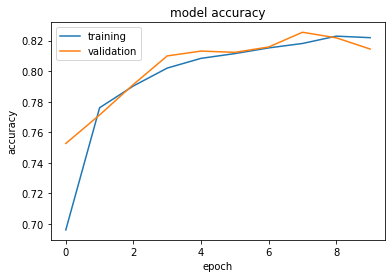

In [14]:
print(history.history)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training', 'validation'], loc='best')

plt.show()

It is even possible to take a better look at the (mis)predictions that the model has made and display them in a confusion matrix. In the code below we have included an example of how you would display this confusion matrix in a graph. The columns in the graph represent the predicted labels from the model and the rows represent the actual labels from the training data. 


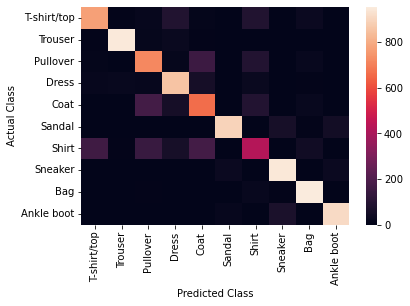

tf.Tensor(
[[771   6  18  83   9   1  85   0  27   0]
 [  5 948  14  26   4   0   1   0   2   0]
 [ 10   2 718  12 150   0  86   0  22   0]
 [ 17  22  17 858  55   1  23   0   7   0]
 [  0   2 169  54 663   2  88   0  22   0]
 [  0   0   0   1   0 892   0  57   5  45]
 [160   5 143  56 170   0 424   0  42   0]
 [  0   0   0   0   0  27   0 946   0  27]
 [  0   2   6   3   3   3  21   7 955   0]
 [  0   0   0   1   0  15   1  69   2 912]], shape=(10, 10), dtype=int32)


In [15]:
import tensorflow as tf
import seaborn as sns
from tensorflow import math as tfmath

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model(x_test_flat), axis=1)

conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes=num_classes)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

**Q2. Which classes does the model find more difficult to predict?**

*The first element (row 0 col 0) corresponds with the number of elements that have been properly classified for class 0.
The elements next to that, (row 0, col 1 and beyond) correspond with the missclassified elements of the class 0. 

Based on this reading, it seems that the model finds it difficult to predict pullovers and shirts. This becomes apparent by the fact that in those rows there are many misclassified elements. Take for instance row 3 for pullovers, in which the model often classifies actual pullovers as coats or shirts. 

there are also other classes at which the model misclassifies, but not as 
*

**Q3. Which classes does the model "confuse" with other classes? Why do you think this is the case?**

*The model seems to "confuse" pullovers as coats or shirts and vice versa. I suspect that this is the case because pullovers, coats and shirts can often have similar shapes, so the function that distinguishes between the three may be similar and the model can have difficulty distinguishing between them. 

It also seems to confuse shirts with t-shirts/tops. Notable, it makes the mistake of misclassifying shirts as t-shirts/tops, more often than it makes the mistake of classifying t-shirts or tops as shirts. So from this data, it seems that the model might be biased towards t-shirts/tops in relation to things that look like shirts, thirts, and tops.*

## Hand-coded CNN

To demonstrate that we can extract more information from the image before flattening it and inserting it into our fully connected network, we will manually create a series of feature maps. To make it a fair comparison with the network above, we will use the exact same settings when creating the fully connected network in which these feature maps will be inserted. Essentially, we are adding the feature extraction phase.

First, we will apply four different filters to each of the images. These four filters will produce four feature maps for every image, each of the exact same size as the image. Entering these four feature maps directly into our fully connected network would be unfair, as the number of input parameters would then be four times as large. However, we can, as a second step, decrease this size by applying pooling. To decrease the size by a factor of four, we can use a kernel size of $(2, 2)$ and a stride of 2. After doing this, we can stitch these four feature maps together and flatten them, resulting in an input vector of the exact same size as the original image. 

### Assignment 8: Feature maps

Implement the function `create_fmaps` that accepts a list of four `filters`, and applies these filters to every image within the `data`. We've already included an array `fmaps` of the correct size, which will reuse four filters you've defined in the first part of the assignment.

For each filter in the `filters` list, you should convolve the filter with every image in the dataset, and store the solution in `fmaps`. Use the function we named [`fast_convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) to apply your convolutions. This function by *Scipy* is highly optimized and probably runs a lot faster than our implementation of convolution (in our testing, this function was almost 20 times as fast!). Keep in mind that it still might take a couple of minutes to run. Make sure to pass the function `mode="same"` to ensure that input and output are the same size.

The result of `create_fmaps` should be a 4-dimensional array, where the first axis corresponds to the number of filters, so this will always be 4. The second axis is the number of elements in the training set, which was the first axis of the original training data array. The last two remaining axes are the height and width of the images in training data, which here will both be 28.

**Note:** You can use different filters than the ones we choose here, but make sure that there are always four filters to make sure the output is the correct size.

In [16]:
from scipy.signal import convolve as fast_convolve

filters = [gauss_filter, sharp_filter, x_sobel_filter, y_sobel_filter]

def create_fmaps(filters, data):
    '''
    Function accepts a list of four filters, and applies these filters to every image within the data
    '''
    
    # set fmaps
    fmaps = np.zeros((4, data.shape[0], data.shape[1], data.shape[2]))
    
    # loop over data
    for index_1, filt in enumerate(filters):
        
        # get each filter in the filters list
        for index_2, image in enumerate(data):
                
            # convolve the filter with every image in the dataset
            filtered = fast_convolve(image, filt, mode = 'same')
                
            # store average in correct place in fmaps
            fmaps[index_1, index_2] = filtered

    return fmaps

fmaps_train = create_fmaps(filters, x_train)
fmaps_test = create_fmaps(filters, x_test)

### Assignment 9: Pooling features

As a second step, implement the function `pool_fmaps`, that applies max pooling to each `fmap`. This function should be almost the exact same as the previous function you wrote; first, loop over each feature map in `fmaps`, then for every image in this feature map, apply max pooling. To aid with optimization, use the function [`fast_pool`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce) to apply max pooling. This function assumes a stride that is set such that the kernels do not overlap, so the three arguments you should give to this function are: the image, the kernel size, and the function to be applied to each of the kernels, which is `np.max` in our case.

In [17]:
from skimage.measure import block_reduce as fast_pool

def pool_fmaps(fmaps):
    
    # We create feature maps that are 4 times as small, so each dimension of the image should be 2 times as small
    fmaps_small = np.zeros((fmaps.shape[0], fmaps.shape[1], fmaps.shape[2]//2, fmaps.shape[3]//2))
    
    # loop over data
    for index_1, filt in enumerate(fmaps):
        
        # get each filter in the filters list
        for index_2, image in enumerate(filt):
        
            # apply max_pool; kernel size (2,2)
            max_pool = fast_pool(image, block_size = ((2,2)), func = np.max)

            # store average in correct place for the blurred image 
            fmaps_small[index_1, index_2] = max_pool
        
    return fmaps_small
    
fmaps_train_small = pool_fmaps(fmaps_train)
fmaps_test_small = pool_fmaps(fmaps_test)

Now, as a final step, we flatten these four feature maps and stitch them together, resulting in a series of input vectors of the exact same size as the original images. Inserting these into an NN that is equivalent to the one we have used previously, will hopefully yield better results!

In [18]:
model2 = build_neural_net(image_size, 64, num_classes)

# Reshape to vectors, but keep the feature maps separated
fmaps_train_flat = fmaps_train_small.reshape((4, x_train.shape[0], image_size//4))
fmaps_test_flat = fmaps_test_small.reshape((4, x_test.shape[0], image_size//4))

# Recombine these small feature maps into one big feature map
fmaps_train_flat = np.concatenate(fmaps_train_flat, axis=1)
fmaps_test_flat = np.concatenate(fmaps_test_flat, axis=1)

# Train our model
history2 = model2.fit(fmaps_train_flat, y_train, epochs=10, batch_size=128, validation_split=.1)

# See how it scored!
loss2, accuracy2  = model2.evaluate(fmaps_test_flat, y_test)

# Print to 3 decimals
print(f'Test loss: {loss2:.3}')
print(f'Test accuracy: {accuracy2:.3}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 49us/sample - loss: 0.8679 - accuracy: 0.7165 - val_loss: 0.6129 - val_accuracy: 0.7670
Epoch 2/10
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5753 - accuracy: 0.7933 - val_loss: 0.5357 - val_accuracy: 0.8072
Epoch 3/10
54000/54000 [==============================] - 2s 28us/sample - loss: 0.5270 - accuracy: 0.8099 - val_loss: 0.5232 - val_accuracy: 0.8072
Epoch 4/10
54000/54000 [==============================] - 1s 25us/sample - loss: 0.5033 - accuracy: 0.8185 - val_loss: 0.4915 - val_accuracy: 0.8180
Epoch 5/10
54000/54000 [==============================] - 1s 22us/sample - loss: 0.4935 - accuracy: 0.8229 - val_loss: 0.4800 - val_accuracy: 0.8257
Epoch 6/10
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4788 - accuracy: 0.8304 - val_loss: 0.4782 - val_accuracy: 0.8283
Epoch 7/10
54000/54000 [==============================] -

Comparing them in a plot, we can see that the hand-coded CNN performs better than our original NN!

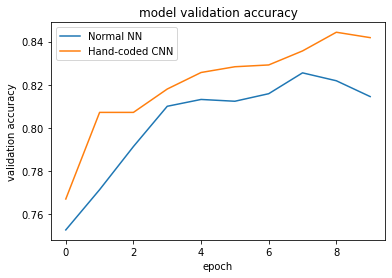

In [19]:
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')

plt.legend(['Normal NN', 'Hand-coded CNN'], loc='best')

plt.show()

### Assignment 10: Using `Keras`'s CNN

The next step for us is to not use our predefined filters, but to use `Keras`'s [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) that enables us to learn the best filters to use for this classification task. In the function below, implement a model using [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), and [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten). Make sure that the model is identical to the hand-coded CNN we built above: it should have a convolutional layer with 4 filters of size (3, 3), an input shape of (28, 28, 1), a max pooling layer, a flattening layer, and then the same dense layers as the original model. 

**Hint:** Take a good look at the function `build_neural_net`. The convolutional net should use the same structure of adding layers to the `Sequential` object, but instead start with `Conv2D`, `MaxPool2D`, and `Flatten`. 

In [20]:
def build_conv_net(image_size, hidden_nodes, num_classes):
    
    # Create a sequential model object
    model = models.Sequential()
    
    # convolutional layer
    model.add(tf.keras.layers.Conv2D(4, (3, 3), input_shape = (28, 28, 1)))
    
    # maxpool layer
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # Create the hidden layer with sigmoid activations
    model.add(layers.Dense(units=hidden_nodes, activation='sigmoid', input_shape=(784,)))
    
    # Create the output layer with softmax activations
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    
    # Compile the network with the appropriate loss function and keep track of accuracy
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Get our number of samples
train_samples = x_train.shape[0]
test_samples = x_test.shape[0]

# Assume the image is square
image_size = x_train.shape[1]

x_train_conv = x_train.reshape((train_samples, image_size, image_size, 1))
x_test_conv = x_test.reshape((test_samples, image_size, image_size, 1))

model3 = build_conv_net(image_size, 64, num_classes)

# Train our model
history3 = model3.fit(x_train_conv, y_train, epochs=10, batch_size=128, validation_split=.1)

# See how it scored!
loss3, accuracy3  = model3.evaluate(x_test_conv, y_test)

# Print to 3 decimals
print(f'Test loss: {loss3:.3}')
print(f'Test accuracy: {accuracy3:.3}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 9s 165us/sample - loss: 0.7846 - accuracy: 0.7519 - val_loss: 0.5360 - val_accuracy: 0.8108
Epoch 2/10
54000/54000 [==============================] - 10s 178us/sample - loss: 0.4882 - accuracy: 0.8271 - val_loss: 0.4627 - val_accuracy: 0.8363
Epoch 3/10
54000/54000 [==============================] - 8s 152us/sample - loss: 0.4371 - accuracy: 0.8457 - val_loss: 0.4297 - val_accuracy: 0.8432
Epoch 4/10
54000/54000 [==============================] - 8s 157us/sample - loss: 0.4087 - accuracy: 0.8554 - val_loss: 0.4159 - val_accuracy: 0.8493
Epoch 5/10
54000/54000 [==============================] - 9s 159us/sample - loss: 0.3979 - accuracy: 0.8604 - val_loss: 0.4050 - val_accuracy: 0.8532
Epoch 6/10
54000/54000 [==============================] - 14s 257us/sample - loss: 0.3816 - accuracy: 0.8655 - val_loss: 0.3952 - val_accuracy: 0.8577
Epoch 7/10
54000/54000 [=========================

Comparing in a plot again, we can see that this model performs even better due to the extra flexibility in the learning of the best filters to use! 

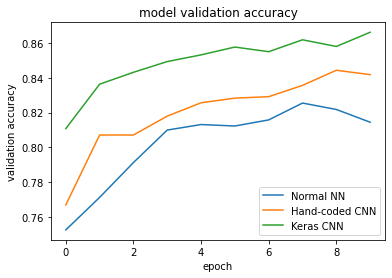

In [21]:
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])

plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')

plt.legend(['Normal NN', 'Hand-coded CNN', 'Keras CNN'], loc='best')

plt.show()